# Fisheries competition

In this notebook we're going to investigate a range of different techniques for the [Kaggle fisheries competition](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring). In this competition, The Nature Conservancy asks you to help them detect which species of fish appears on a fishing boat, based on images captured from boat cameras of various angles. Your goal is to predict the likelihood of fish species in each picture. Eight target categories are available in this dataset: Albacore tuna, Bigeye tuna, Yellowfin tuna, Mahi Mahi, Opah, Sharks, Other 

You can use [this](https://github.com/floydwch/kaggle-cli) api to download the data from Kaggle.

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.plots import *
from fastai.io import get_data

PATH = "data/fisheries/"

## First look at fish pictures

In [2]:
!ls {PATH}

annos	  sample_submission_stg1.csv  test_stg2.7z  trn_bb_corners_labels
images	  sample_submission_stg2.csv  tmp	    trn_bb_labels
__MACOSX  test_stg1		      train
models	  test_stg2		      train.csv


In [3]:
!ls {PATH}train

ALB  BET  DOL  LAG  NoF  OTHER	SHARK  YFT


In [4]:
files = !ls {PATH}train/ALB | head
files

['img_00003.jpg',
 'img_00010.jpg',
 'img_00012.jpg',
 'img_00015.jpg',
 'img_00019.jpg',
 'img_00020.jpg',
 'img_00029.jpg',
 'img_00032.jpg',
 'img_00037.jpg',
 'img_00038.jpg']

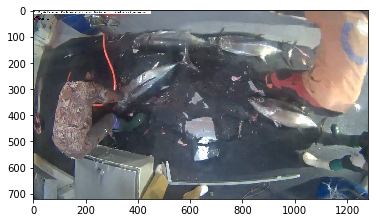

In [5]:
img = plt.imread(f'{PATH}train/ALB/{files[0]}')
plt.imshow(img);

## Data pre-processing

Here we are changing the structure of the training data to make it more convinient. We will have all images in a common directory `images` and will have a file `train.csv` with all labels. 

In [6]:
from os import listdir
from os.path import join
train_path = f'{PATH}/train'

In [7]:
dirs = [d for d in listdir(train_path) if os.path.isdir(join(train_path,d))]
print(dirs)

['LAG', 'YFT', 'SHARK', 'ALB', 'NoF', 'OTHER', 'BET', 'DOL']


In [8]:
train_dict = {d: listdir(join(train_path, d)) for d in dirs}

In [9]:
train_dict["LAG"][:10]

['img_04352.jpg',
 'img_05449.jpg',
 'img_04678.jpg',
 'img_00657.jpg',
 'img_01037.jpg',
 'img_00784.jpg',
 'img_05386.jpg',
 'img_04953.jpg',
 'img_02236.jpg',
 'img_06876.jpg']

In [10]:
sum(len(v) for v in train_dict.values())

3777

In [11]:
with open(f"{PATH}train.csv", "w") as csv:
    csv.write("img,label\n")
    for d in dirs:
        for f in train_dict[d]: csv.write(f'{f},{d}\n')

In [12]:
img_path = f'{PATH}images'
os.makedirs(img_path, exist_ok=True)

In [13]:
!cp {PATH}train/*/*.jpg {PATH}images/

## Our first model with Center  Cropping

Here we import the libraries we need. We'll learn about what each does during the course.

In [14]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

In [15]:
sz=350
bs=64
csv_fname = os.path.join(PATH, "train.csv")
train_labels = list(open(csv_fname))
n = len(list(open(csv_fname)))-1
val_idxs = get_cv_idxs(n)

In [16]:
tfms = tfms_from_model(resnet34, sz)
data = ImageClassifierData.from_csv(PATH, "images", csv_fname, bs, tfms, val_idxs)

In [17]:
learn = ConvLearner.pretrained(resnet34, data, precompute=True, opt_fn=optim.Adam, ps=0.5)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 88%|████████▊ | 42/48 [00:04<00:00, 10.14it/s, loss=8.03]


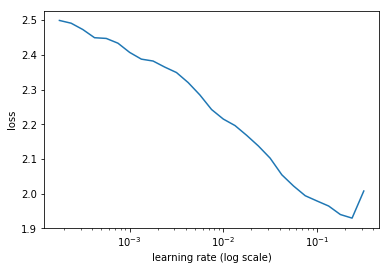

In [18]:
lrf=learn.lr_find()
learn.sched.plot()

In [19]:
learn.fit(0.05, 4, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[0.      1.4712  0.77306 0.75904]                         
[1.      1.1582  0.6081  0.80757]                         
[2.      0.79765 0.49173 0.84046]                          
[3.      0.84608 0.61726 0.81799]                          
[4.      0.81182 0.35272 0.87919]                          
[5.      0.62431 0.4495  0.86617]                          
[6.      0.48686 0.37959 0.88212]                          
[7.      0.63612 0.55885 0.84403]                          
[8.      0.98783 0.67249 0.82935]                          
[9.      0.97608 0.55007 0.85118]                          
[10.       0.83013  0.54566  0.83686]                      
[11.       0.64843  0.36194  0.88276]                      
[12.       0.50019  0.41747  0.88179]                      
[13.       0.42617  0.3462   0.9036 ]                      
[14.       0.37216  0.49452  0.88309]                      



In [20]:
learn.save('fisheries_05')

In [22]:
lrs=np.array([1e-4,1e-3,1e-2])
learn.precompute=False

learn.freeze_to(6)
lrf=learn.lr_find(lrs/1e3)
learn.sched.plot()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  0%|          | 0/48 [00:00<?, ?it/s]


RuntimeError: element 0 of variables does not require grad and does not have a grad_fn

## Same model with No cropping 

NOTE: Before running this remove the temp file under data/fish.

In [24]:
sz = 350
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO)
data = ImageClassifierData.from_csv(PATH, "images", csv_fname, bs, tfms, val_idxs)

In [25]:
learn = ConvLearner.pretrained(resnet34, data, precompute=True, opt_fn=optim.Adam, ps=0.5)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 48%|████▊     | 23/48 [00:00<00:00, 45.82it/s, loss=9.94]


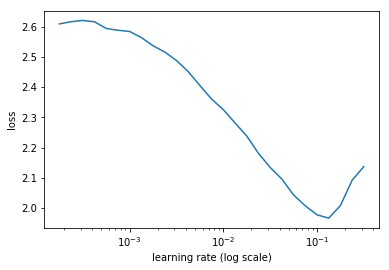

In [26]:
lrf=learn.lr_find()
learn.sched.plot()

In [27]:
learn.fit(0.01, 4, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

[0.      1.0873  0.63223 0.77499]                         
[1.      0.78502 0.53356 0.82871]                          
[2.      0.57303 0.38769 0.86517]                          
[3.      0.50186 0.39667 0.86486]                          
[4.      0.47965 0.40801 0.85281]                          
[5.      0.3794  0.36191 0.90002]                          
[6.      0.31099 0.37441 0.87919]                          
[7.      0.31387 0.37906 0.89157]                          
[8.      0.36096 0.28083 0.9088 ]                          
[9.      0.33944 0.32785 0.90686]                          
[10.       0.31896  0.26778  0.9316 ]                      
[11.       0.2743   0.29505  0.92022]                      
[12.       0.23991  0.18751  0.93584]                      
[13.       0.19461  0.22425  0.93617]                      
[14.       0.17263  0.25023  0.93878]                      



HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 83%|████████▎ | 40/48 [00:31<00:06,  1.26it/s, loss=4.43]

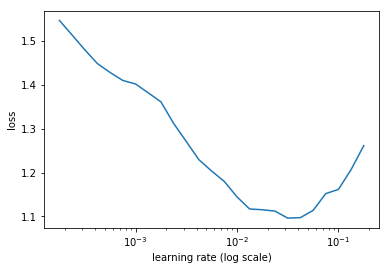

In [28]:
lrs=np.array([1e-4,1e-3,1e-2])
learn.precompute=False

learn.unfreeze()
lrf=learn.lr_find(lrs/1e3)
learn.sched.plot()

In [29]:
lrs=np.array([1e-5,1e-4,1e-3])
learn.fit(lrs, 5, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=31), HTML(value='')))

  8%|▊         | 4/48 [00:04<00:54,  1.23s/it, loss=1.54] 


Exception in thread Thread-45:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



[0.      0.68915 0.3777  0.86943]                          
[1.      0.34964 0.33321 0.88669]                          
[2.      0.18541 0.30373 0.89841]                          
[3.      0.12399 0.34751 0.88927]                          
[4.      0.1879  0.46346 0.84434]                          
[5.      0.15445 0.43403 0.85736]                          
[6.      0.1215  0.43243 0.8616 ]                          
[7.      0.10022 0.41252 0.87168]                           
[8.      0.08565 0.47154 0.8642 ]                           
[9.      0.05447 0.43097 0.87104]                           
[10.       0.0453   0.42658  0.87138]                       
[11.       0.03187  0.40945  0.87431]                       
[12.       0.02721  0.41835  0.87919]                       
[13.       0.02353  0.43153  0.86877]                       
[14.       0.02019  0.3888   0.87952]                       
[15.       0.01792  0.43277  0.87301]                       
[16.       0.01593  0.45431  0.

KeyboardInterrupt: 

## Predicting bounding boxes

### Getting bounding boxes data

This part needs to run just the first time to get the file `trn_bb_labels`

In [23]:
import json
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']

In [24]:
def get_annotations():
    annot_urls = [
        '5458/bet_labels.json', '5459/shark_labels.json', '5460/dol_labels.json',
        '5461/yft_labels.json', '5462/alb_labels.json', '5463/lag_labels.json'
    ]
    cache_subdir = os.path.abspath(os.path.join(PATH, 'annos'))
    url_prefix = 'https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/'
    os.makedirs(cache_subdir, exist_ok=True)
    
    for url_suffix in annot_urls:
        fname = url_suffix.rsplit('/', 1)[-1]
        get_data(url_prefix + url_suffix, f'{cache_subdir}/{fname}')

In [25]:
# run this code to get annotation files
get_annotations()

In [26]:
# creates a dictionary of all annotations per file
bb_json = {}
for c in anno_classes:
    if c == 'other': continue # no annotation file for "other" class
    j = json.load(open(f'{PATH}annos/{c}_labels.json', 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            bb_json[l['filename'].split('/')[-1]] = sorted(
                l['annotations'], key=lambda x: x['height']*x['width'])[-1]
bb_json['img_04908.jpg']

{'class': 'rect',
 'height': 246.75000000000074,
 'width': 432.8700000000013,
 'x': 465.3000000000014,
 'y': 496.32000000000147}

In [27]:
raw_filenames = pd.read_csv(csv_fname)["img"].values

In [28]:
file2idx = {o:i for i,o in enumerate(raw_filenames)}

empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}
for f in raw_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox

bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb):
    bb = [bb[p] for p in bb_params]
    bb[2] = max(bb[2], 0)
    bb[3] = max(bb[3], 0)
    return bb

In [29]:
trn_bbox = np.stack([convert_bb(bb_json[f]) for f in raw_filenames]).astype(np.float32)
trn_bb_labels = [f + ',' + ' '.join(map(str,o))+'\n' for f,o in zip(raw_filenames,trn_bbox)]

In [30]:
open(f'{PATH}trn_bb_labels', 'w').writelines(trn_bb_labels)

In [31]:
fnames,csv_labels,_,_ = parse_csv_labels(f'{PATH}trn_bb_labels', skip_header=False)

In [32]:
def bb_corners(bb):
    bb = np.array(bb, dtype=np.float32)
    row1 = bb[3]
    col1 = bb[2]
    row2 = row1 + bb[0]
    col2 = col1 + bb[1]
    return [row1, col1, row2, col2]

In [33]:
f = 'img_02642.jpg'
bb = csv_labels[f]
print(bb)
bb_corners(bb)

['195.92665', '320.60724', '954.6971', '699.39874']


[699.39874, 954.6971, 895.3254, 1275.3043]

In [34]:
new_labels = [f + "," + " ".join(map(str, bb_corners(csv_labels[f]))) + "\n" for f in raw_filenames]

In [35]:
open(f'{PATH}trn_bb_corners_labels', 'w').writelines(new_labels)

### Looking at bounding boxes

In [36]:
# reading bb file
bbox = {}
bb_data = pd.read_csv(f'{PATH}trn_bb_labels', header=None)

In [37]:
fnames,csv_labels,_,_ = parse_csv_labels(f'{PATH}trn_bb_labels', skip_header=False)
fnames,corner_labels,_,_ = parse_csv_labels(f'{PATH}trn_bb_corners_labels', skip_header=False)

In [38]:
corner_labels["img_06297.jpg"]

['396.21', '404.67', '504.78', '623.22003']

In [39]:
csv_labels["img_06297.jpg"]

['108.57', '218.55', '404.67', '396.21']

In [40]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

def show_bb(path, f='img_04908.jpg'):
    file_path = f'{path}images/{f}'
    bb = csv_labels[f]
    plots_from_files([file_path])
    plt.gca().add_patch(create_rect(bb))

In [41]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color, fill=False, lw=3)

def show_corner_bb(path, f='img_04908.jpg'):
    file_path = f'{path}images/{f}'
    bb = corner_labels[f]
    plots_from_files([file_path])
    plt.gca().add_patch(create_corner_rect(bb))

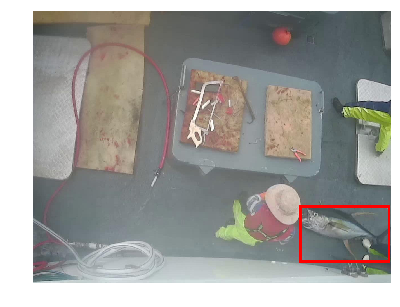

In [49]:
show_corner_bb(PATH, f = 'img_02642.jpg')

### Model predicting bounding boxes

In [94]:
sz=299
bs=64

label_csv=f'{PATH}trn_bb_corners_labels'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [95]:
# tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD)
# data = ImageClassifierData.from_csv(PATH, 'images', label_csv, tfms=tfms, val_idxs=val_idxs,
#                                     continuous=True, skip_header=False, test_name='test_stg1')

In [110]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO) #, tfm_y=TfmType.COORD)
data = ImageClassifierData.from_csv(PATH, 'images', label_csv, tfms=tfms, val_idxs=val_idxs,
                                    continuous=True, skip_header=False, test_name='test_stg1')

In [111]:
trn_ds = data.trn_dl.dataset

In [112]:
x, y = trn_ds[0]

In [113]:
print(x.shape, y)

(3, 299, 299) [466. 546. 735. 951.]


In [114]:
learn = ConvLearner.pretrained(resnet34, data, precompute=True, opt_fn=optim.Adam, ps=0.5)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[   0.       393.83862 6692.55322]                       



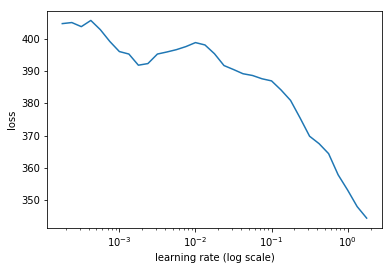

In [115]:
lrf=learn.lr_find()
learn.sched.plot()

In [116]:
learn.fit(0.01, 5, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=31), HTML(value='')))

[  0.      378.93229 375.86279]                          
[  1.      303.30189 190.87085]                          
[  2.      221.0447  169.49191]                          
[  3.      179.29808 142.79742]                          
[  4.      152.77239 128.90834]                          
[  5.      136.45651 125.31303]                          
[  6.      129.26422 122.45401]                          
[  7.      125.67132 120.38361]                          
[  8.      120.61004 112.47843]                          
[  9.      115.79607 109.25491]                          
[ 10.      112.90552 105.7262 ]                          
[ 11.      108.82431 101.56278]                          
[ 12.      107.77759 104.28991]                          
[ 13.      104.99834 101.48515]                          
[ 14.      104.19534 100.87192]                          
[ 15.      103.65255 100.54662]                          
[ 16.      104.64682  98.01046]                          
[ 17.      104

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[0.00000e+00 2.12586e+02 6.70744e+14]                    



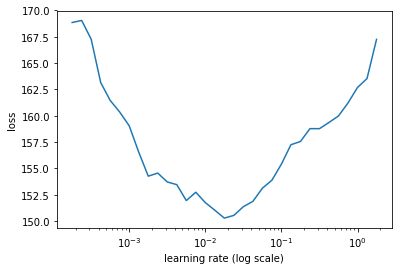

In [117]:
lrs=np.array([1e-4,1e-3,1e-2])
learn.precompute=False

learn.unfreeze()
lrf=learn.lr_find(lrs/1e3)
learn.sched.plot()

In [ ]:
lrs=np.array([1e-5,1e-4,1e-3])
learn.fit(lrs, 5, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=31), HTML(value='')))

[  0.      125.61325 112.07028]                          
[  1.      108.14569 108.29909]                          
[  2.       95.37653 108.4031 ]                           
[  3.       95.55771 106.06689]                           
[  4.       89.79965 112.09869]                           
[  5.       82.61171 108.0448 ]                           
[  6.      78.5975 107.9833]                              
[  7.       80.17377 106.46045]                           
[  8.       78.34964 109.48812]                           
[  9.       76.14526 108.01678]                           
[ 10.       75.10312 106.25338]                           
[ 11.       72.29397 106.76656]                           
[ 12.       69.39659 105.1008 ]                           
[ 13.       67.37871 103.86672]                           
[ 14.       65.78931 103.18307]                           
[ 15.       68.30555 104.16668]                           
[ 16.       69.35767 103.09742]                           

In [62]:
learn.save('fish_bounding_boxes')

In [48]:
learn.load('fish_bounding_boxes')

### Predictions

In [52]:
test_ds = data.test_ds

In [56]:
test_ds = data.test_dl.dataset

In [61]:
len(trn_ds)

3022

In [67]:
len(test_ds)

1000

In [63]:
test_ds

In [92]:
lcsv = pd.read_csv(label_csv)

In [93]:
lcsv.head()

,img_04352.jpg,350.0 680.0 498.0 863.0
0,img_05449.jpg,353.0 686.0 498.0 856.0
1,img_04678.jpg,118.0 528.0 495.0 943.0
2,img_00657.jpg,335.0 827.0 454.0 1008.0
3,img_01037.jpg,319.0 699.0 431.0 884.0
4,img_00784.jpg,175.0 612.0 508.0 996.0


In [81]:
bbox_0 = learn.predict_array([trn_ds[0][0]])[0]

In [83]:
trn_ds.fnames[0]

array(['images/img_00004.jpg', 'images/img_00008.jpg', 'images/img_00010.jpg', ..., 'images/img_07917.jpg',
       'images/img_07922.jpg', 'images/img_07923.jpg'], dtype='<U20')

In [85]:
bbox_0

array([ -3.3844 ,  -0.21825,  -6.66813, -12.98029,  -5.08337,  -3.07091,  -8.03864,  -2.22555], dtype=float32)

In [89]:
np.exp(bbox_0)

array([0.0339 , 0.80392, 0.00127, 0.     , 0.0062 , 0.04638, 0.00032, 0.10801], dtype=float32)

In [87]:
corner_labels

{'img_04352.jpg': ['350.0', '680.0', '498.0', '863.0'],
 'img_05449.jpg': ['353.0', '686.0', '498.0', '856.0'],
 'img_04678.jpg': ['118.0', '528.0', '495.0', '943.0'],
 'img_00657.jpg': ['335.0', '827.0', '454.0', '1008.0'],
 'img_01037.jpg': ['319.0', '699.0', '431.0', '884.0'],
 'img_00784.jpg': ['175.0', '612.0', '508.0', '996.0'],
 'img_05386.jpg': ['55.0', '707.0', '447.0', '1073.0'],
 'img_04953.jpg': ['55.0', '704.0', '446.0', '1070.0'],
 'img_02236.jpg': ['309.0', '697.0', '432.0', '883.0'],
 'img_06876.jpg': ['354.0', '685.0', '499.0', '849.0'],
 'img_04199.jpg': ['295.0', '529.0', '461.0', '748.0'],
 'img_07334.jpg': ['352.0', '690.0', '499.0', '863.0'],
 'img_04734.jpg': ['57.0', '710.0', '447.0', '1071.0'],
 'img_01457.jpg': ['124.0', '708.0', '454.0', '1074.0'],
 'img_03232.jpg': ['295.0', '826.0', '456.0', '923.0'],
 'img_03774.jpg': ['317.0', '755.0', '432.0', '885.0'],
 'img_02349.jpg': ['320.0', '748.0', '431.0', '877.0'],
 'img_05123.jpg': ['299.0', '837.0', '462.0', 

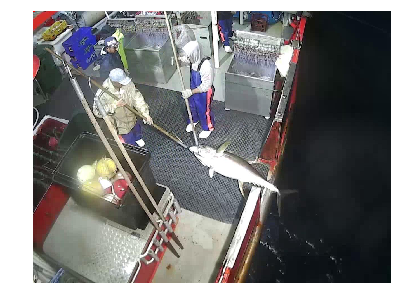

In [84]:
def show_corner_bb(path, f, bb):
    file_path = f'{path}{f}'
#     bb = corner_labels[f]
    plots_from_files([file_path])
    plt.gca().add_patch(create_corner_rect(bb))
    
show_corner_bb(PATH, trn_ds.fnames[0], bbox_0)

## Looking into size of images

In [60]:
f="img_06297.jpg"
PIL.Image.open(PATH+"images/" + f).size

(1280, 720)

In [61]:
sizes = [PIL.Image.open(PATH+f).size for f in data.trn_ds.fnames]
raw_val_sizes = [PIL.Image.open(PATH+f).size for f in data.val_ds.fnames]

In [63]:
1

1